# Converting a Keras model to an SNN on Loihi

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/keras-to-loihi.ipynb)

This notebook describes how to train a network in Keras and convert it to a spiking
neural network (SNN) to run on Loihi. Intel's Loihi chip is a type of "neuromorphic"
hardware—specialized neural network acceleration hardware that uses spike-based
communication like neurons in the brain. In this tutorial, will look at how to set up
our network to target and run on Intel's Loihi chip using the NengoLoihi backend. While
in general the Nengo ecosystem allows users to switch between backends without changes
to their models, we will see how making some Loihi-specific changes during training and
inference allow us to take full advantage of its capabilities.

There are several ways to build SNNs to target NengoLoihi. The [CIFAR-10 Loihi
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html) works through
how to build up a deep spiking network to run on Loihi using the standard Nengo and
NengoDL APIs. In NengoDL's [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html), we looked at
converting a Keras model to an SNN. Here, we will extend the Keras to SNN example,
tailoring the model for execution on Loihi.

The goal of this notebook is to familiarize you with some of the nuances of running SNNs
on the Loihi, and how to set these up starting from a neural network defined in Keras.
The two focuses in this notebook are on adding a network layer that runs off-chip to
transform the input images into spikes, and training using a Loihi neuron model that
captures the unique behaviour of Loihi's quantized neurons. We'll add the network layer
and train and test with normal ReLU neurons first to see what kind of performance we can
expect without quantization constraints. Then we'll train with the Loihi neurons to
improve implementation performance, and finally we'll run the model on Loihi to measure
the final performance (we use a simulated Loihi if actual Loihi hardware is not
available).

In [1]:
import collections
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengo_dl
import numpy as np
import tensorflow as tf

import nengo_loihi

# ignore NengoDL warning about no GPU
warnings.filterwarnings("ignore", message="No GPU", module="nengo_dl")

# The results in this notebook should be reproducible across many random seeds.
# However, some seed values may cause problems, particularly in the `to-spikes` layer
# where poor initialization can result in no information being sent to the chip. We set
# the seed to ensure that good results are reproducible without having to re-train.
np.random.seed(0)
tf.random.set_seed(0)

In this example we'll use the standard [MNIST
dataset](http://yann.lecun.com/exdb/mnist/).

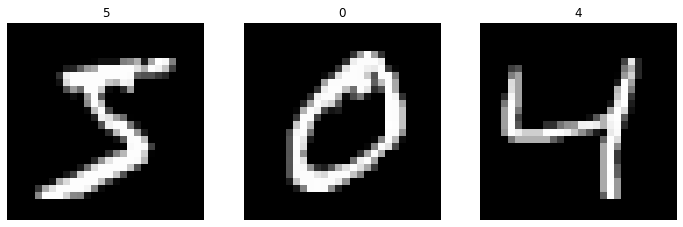

In [2]:
# load in MNIST dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.reshape(train_images[i], (28, 28)), cmap="gray")
    plt.axis("off")
    plt.title(str(train_labels[i, 0, 0]))

## Implementing the network

We will start with the same network structure used in the [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html): Two convolutional
layers and a dense layer.

The only way to communicate with the Loihi is by sending spikes. Usually, when we have a
model that we want to run on neuromorphic hardware, we want the whole model that we've
defined to run on the hardware. Communicating with Loihi, however, requires that we have
at least one layer that runs *off*-chip to convert the input signal to spikes to send to
the rest of the model running on Loihi.

We'll add a `Conv2D` layer to run off-chip and convert the input signal to spikes. This
could also be an `Activation` layer. The advantage to the `Activation` layer is that it
adds no extra parameters and minimizes off-chip computations. The `Conv2D` layer uses a
few parameters, and requires a bit more off-chip computation, but gives the network much
more flexibility as to how pixels are converted to spikes. An `Activation` layer would
likely work well for simple images like MNIST, but for more complex images (e.g. with
more than one color channel, or a wider range of intensity values) the flexibility of
the `Conv2D` layer is important. We avoid layers like the `Dense` layer, as it
significantly increases both the number of parameters and the number of computations
that have to be run off-chip.

On the output side of the network, we now have to worry about how many neurons are in
the last layer run on the chip. We are limited in how many neurons we can record from on
the board, so we add a `Dense` layer with 100 neurons between the last `Conv2D` layer
and our 10-dimensional `Dense` output layer (which runs off-chip). This way, we only
have to record from 100 neurons, rather than the 2,304 neurons we would need to record
from if we connected directly from the last `Conv2D` layer to the 10-dimensional output.
An added benefit is that the amount of off-chip computation is reduced, since the number
of weights used by the off-chip output layer is 100 x 10 instead of 2304 x 10.

In [3]:
inp = tf.keras.Input(shape=(28, 28, 1), name="input")

# transform input signal to spikes using trainable 1x1 convolutional layer
to_spikes_layer = tf.keras.layers.Conv2D(
    filters=3,  # 3 neurons per pixel
    kernel_size=1,
    strides=1,
    activation=tf.nn.relu,
    use_bias=False,
    name="to-spikes",
)
to_spikes = to_spikes_layer(inp)

# on-chip convolutional layers
conv0_layer = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
    use_bias=False,
    name="conv0",
)
conv0 = conv0_layer(to_spikes)

conv1_layer = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
    use_bias=False,
    name="conv1",
)
conv1 = conv1_layer(conv0)

flatten = tf.keras.layers.Flatten(name="flatten")(conv1)

dense0_layer = tf.keras.layers.Dense(units=100, activation=tf.nn.relu, name="dense0")
dense0 = dense0_layer(flatten)

# since this final output layer has no activation function,
# it will be converted to a `nengo.Node` and run off-chip
dense1 = tf.keras.layers.Dense(units=10, name="dense1")(dense0)

model = tf.keras.Model(inputs=inp, outputs=dense1)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
to-spikes (Conv2D)           (None, 28, 28, 3)         3         
_________________________________________________________________
conv0 (Conv2D)               (None, 13, 13, 32)        864       
_________________________________________________________________
conv1 (Conv2D)               (None, 6, 6, 64)          18432     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense0 (Dense)               (None, 100)               230500    
_________________________________________________________________
dense1 (Dense)               (None, 10)                1010  

2022-01-21 13:06:06.315597: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


### Training the networks

As in the Keras-to-SNN notebook, once we create our model we'll use the NengoDL
Converter to translate it into a Nengo network, and then we'll train.

In [4]:
def train(params_file="./keras_to_loihi_params", epochs=1, **kwargs):
    converter = nengo_dl.Converter(model, **kwargs)

    with nengo_dl.Simulator(converter.net, seed=0, minibatch_size=200) as sim:
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss={
                converter.outputs[dense1]: tf.losses.SparseCategoricalCrossentropy(
                    from_logits=True
                )
            },
            metrics={converter.outputs[dense1]: tf.metrics.sparse_categorical_accuracy},
        )
        sim.fit(
            {converter.inputs[inp]: train_images},
            {converter.outputs[dense1]: train_labels},
            epochs=epochs,
        )

        # save the parameters to file
        sim.save_params(params_file)

In [5]:
# train this network with normal ReLU neurons
train(
    epochs=2,
    swap_activations={tf.nn.relu: nengo.RectifiedLinear()},
)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/2


2022-01-21 13:06:09.301844: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-01-21 13:06:09.302516: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


300/300 [==============================] - 6s 10ms/step - loss: 0.1796 - probe_loss: 0.1796 - probe_sparse_categorical_accuracy: 0.9461
Epoch 2/2
300/300 [==============================] - 3s 10ms/step - loss: 0.0486 - probe_loss: 0.0486 - probe_sparse_categorical_accuracy: 0.9852


After training for 2 epochs the non-spiking network achievs around 98% accuracy on the
test data.

Now that we have our trained weights, we can begin the conversion to spiking neurons. To
help us in this process we're going to first define a helper function that will build
the network for us, load weights from a specified file, and make it easy to play around
with some other features of the network.

### Evaluating the networks

We will now define a general function to evaluate our network on the test dataset with
various neural activation functions (both non-spiking and spiking). The function creates
a new network with the desired activation function, loads the weights that we learned
during training, runs the network on the test dataset, and reports accuracy and firing
rate with both `print` statements and plots.

In [6]:
def run_network(
    activation,
    params_file="./keras_to_loihi_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=100,
    n_plots=2,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        scale_firing_rates=scale_firing_rates,
        swap_activations={tf.nn.relu: activation},
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense1]

    # add probes to layers to record activity
    with nengo_converter.net:
        probes = collections.OrderedDict(
            [
                [to_spikes_layer, nengo.Probe(nengo_converter.layers[to_spikes])],
                [conv0_layer, nengo.Probe(nengo_converter.layers[conv0])],
                [conv1_layer, nengo.Probe(nengo_converter.layers[conv1])],
                [dense0_layer, nengo.Probe(nengo_converter.layers[dense0])],
            ]
        )

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=20, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    test_predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    print(
        "Test accuracy: %.2f%%"
        % (100 * np.mean(test_predictions == test_labels[:n_test, 0, 0]))
    )

    # plot the results
    mean_rates = []
    for i in range(n_plots):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
        plt.axis("off")

        n_layers = len(probes)
        mean_rates_i = []
        for j, layer in enumerate(probes.keys()):
            probe = probes[layer]
            plt.subplot(n_layers, 3, (j * 3) + 2)
            plt.suptitle("Neural activities")

            outputs = data[probe][i]

            # look at only at non-zero outputs
            nonzero = (outputs > 0).any(axis=0)
            outputs = outputs[:, nonzero] if sum(nonzero) > 0 else outputs

            # undo neuron amplitude to get real firing rates
            outputs /= nengo_converter.layers[layer].ensemble.neuron_type.amplitude

            rates = outputs.mean(axis=0)
            mean_rate = rates.mean()
            mean_rates_i.append(mean_rate)
            print(
                '"%s" mean firing rate (example %d): %0.1f' % (layer.name, i, mean_rate)
            )

            if is_spiking_type(activation):
                outputs *= 0.001
                plt.ylabel("# of Spikes")
            else:
                plt.ylabel("Firing rates (Hz)")

            # plot outputs of first 100 neurons
            plt.plot(outputs[:, :100])

        mean_rates.append(mean_rates_i)

        plt.xlabel("Timestep")

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][i]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()

    # take mean rates across all plotted examples
    mean_rates = np.array(mean_rates).mean(axis=0)

    return mean_rates


def is_spiking_type(neuron_type):
    return isinstance(neuron_type, (nengo.LIF, nengo.SpikingRectifiedLinear))

Test accuracy: 100.00%
"to-spikes" mean firing rate (example 0): 14.2
"conv0" mean firing rate (example 0): 2.0
"conv1" mean firing rate (example 0): 1.0
"dense0" mean firing rate (example 0): 2.8
"to-spikes" mean firing rate (example 1): 15.6
"conv0" mean firing rate (example 1): 2.3
"conv1" mean firing rate (example 1): 1.4
"dense0" mean firing rate (example 1): 3.7


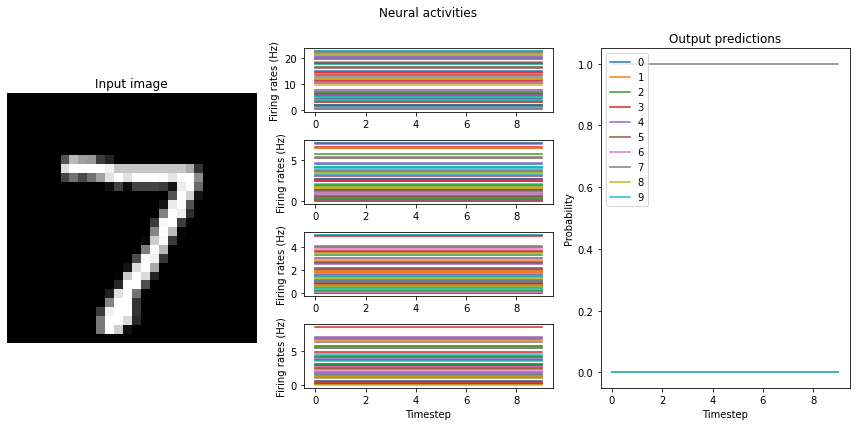

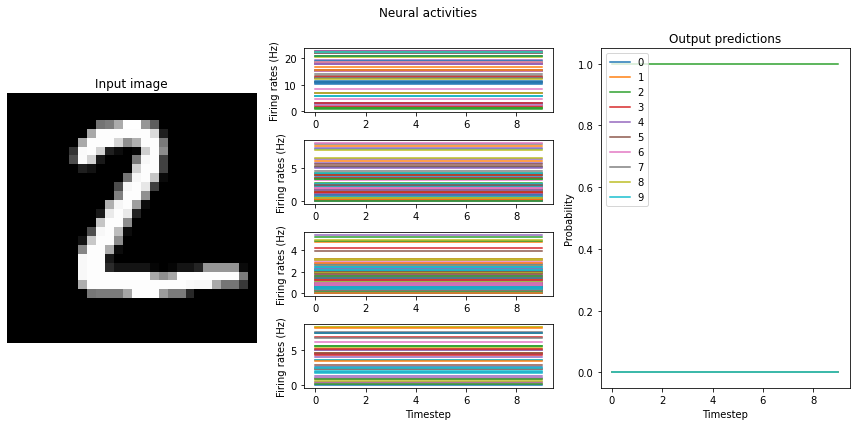

In [7]:
# test the trained networks on test set
mean_rates = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

Note that we're plotting the output over time for consistency with future plots, but
since our network doesn't have any temporal elements (e.g. spiking neurons), the output
is constant for each digit. The firing rates here displayed in the middle graph are
important to note for conversion to spikes, and may vary somewhat depending on the
random initial conditions used for training. One of the important features visible here,
which we'll discuss shortly, is the decreasing mean firing rate as you move through the
network. Note that these mean firing rates are computed across only the neurons that
have non-zero activities; they are therefore the mean rates of the active neurons.

Let's continue with the comparison by moving into spikes.

## Converting to a spiking neural network

Using the NengoDL converter, we can swap all the `relu` activation functions to
`nengo.SpikingRectifiedLinear`. Using the lessons that we learned in the Keras->SNN
example notebook we'll set `synapse=0.005` and `scale_firing_rates=100`.

Test accuracy: 100.00%
"to-spikes" mean firing rate (example 0): 1434.5
"conv0" mean firing rate (example 0): 184.6
"conv1" mean firing rate (example 0): 88.6
"dense0" mean firing rate (example 0): 143.2
"to-spikes" mean firing rate (example 1): 1561.8
"conv0" mean firing rate (example 1): 210.9
"conv1" mean firing rate (example 1): 98.7
"dense0" mean firing rate (example 1): 192.1


array([1498.1554 ,  197.74052,   93.66748,  167.63669], dtype=float32)

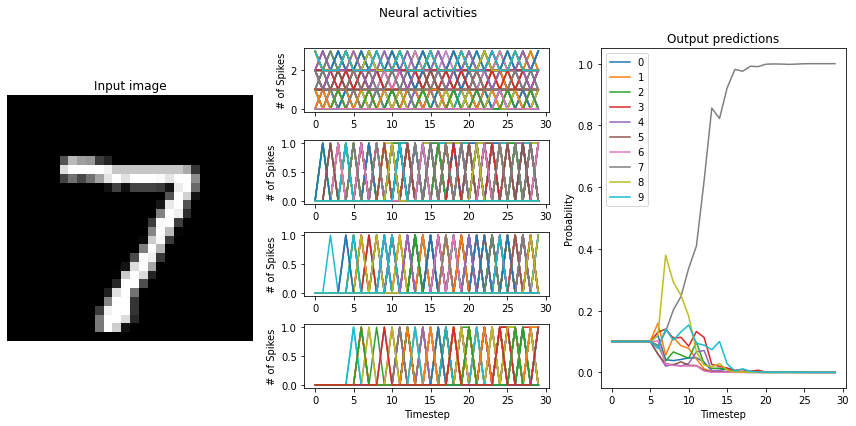

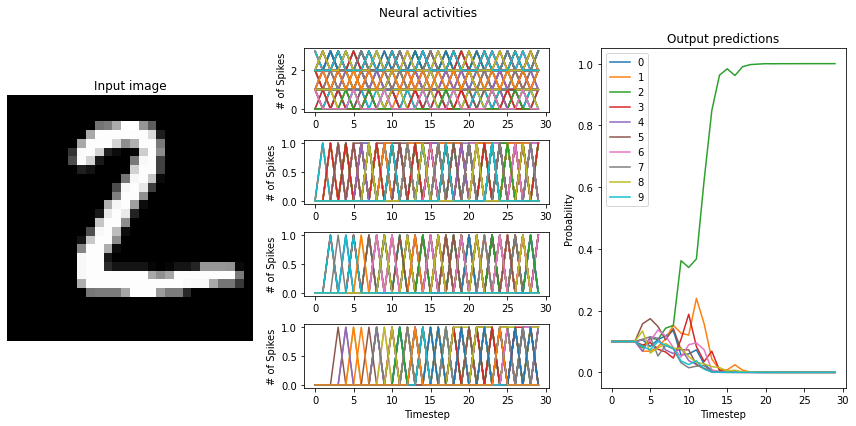

In [8]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo.SpikingRectifiedLinear(),
    scale_firing_rates=100,
    synapse=0.005,
)

An important feature of SNNs is the time required to generate output. The larger your
scaling factor, the quicker the network response to input will be. This is because more
spikes will be generated at each layer, triggering a quicker response at the succeeding
layer.

For still images, where each successive image has no correlation with the previous
image, this leads to a lag in generating output. SNNs are however much more efficient in
a problem like processing a video stream, where there is high correlation between
frames. In general, SNNs perform better in situations with temporal dynamics. For
simplicity, though, we only examine the case of processing still images here.

Let's see what happens when we convert to an SNN using Loihi neurons.

## Converting to SNN using Loihi neurons

To get a sense of how well our network will run on Loihi, we switch to using the
`LoihiSpikingRectifiedLinear` activation profile.

Note that the on-chip restrictions don't apply to the input layer that we added to the
network, because it won't be running on the Loihi. Here, the performance differences are
minimal so we just convert all neurons over to Loihi neurons. If you find that adding
the input layer is causing a performance drop, you may want to build your network such
that only the on-chip layers use the NengoLoihi neurons and the off-chip layer uses a
standard spiking neuron model (i.e. `SpikingRectifiedLinear`).

Test accuracy: 89.00%
"to-spikes" mean firing rate (example 0): 792.1
"conv0" mean firing rate (example 0): 92.8
"conv1" mean firing rate (example 0): 47.5
"dense0" mean firing rate (example 0): 36.5
"to-spikes" mean firing rate (example 1): 834.5
"conv0" mean firing rate (example 1): 102.7
"conv1" mean firing rate (example 1): 48.8
"dense0" mean firing rate (example 1): 38.1


array([813.3253  ,  97.74296 ,  48.18663 ,  37.301582], dtype=float32)

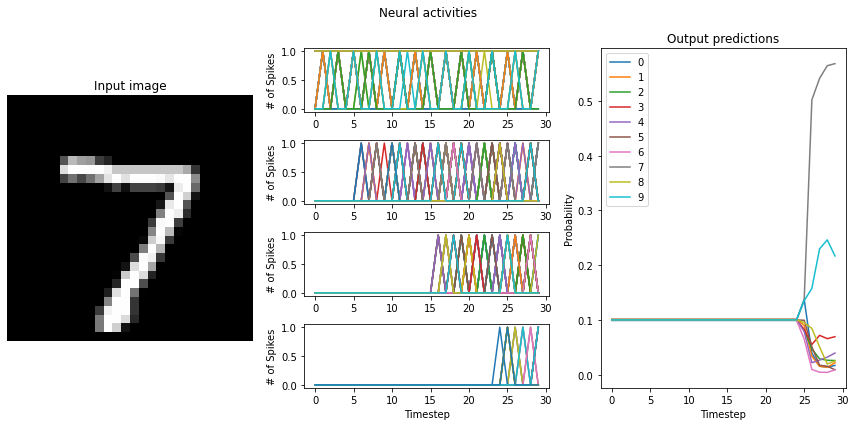

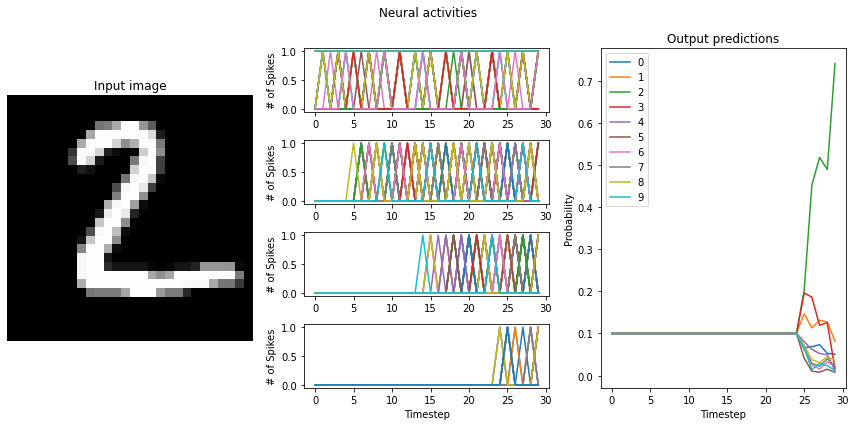

In [9]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    scale_firing_rates=100,
    synapse=0.005,
)

If the training resulted a network with large differences between the firing rates (>
10Hz) of the network layers, switching to `LoihiSpikingRectifiedLinear` neurons will
cause a significant decrease in the performance of the network. What causes this?

Basically, the issue is that each of the layers need different scaling terms. With large
firing rate discrepancies between layers, we end up trying to balance between having a
`scale_firing_rate` value for the network that 1) is high enough to achieve good
performance from the network, but 2) is low enough to not induce multiple spikes per
time step in any layer. The second point here is where we're getting tripped up.

Loihi neurons can only spike once per time step. Recall that while the
`scale_firing_rates` term increases the gain on signals going into neurons, it also
correspondingly decreases the `amplitude` of the neuron activity output. If
`scale_firing_rates` is set high enough to expect three spikes per time step, but only
one spike comes out, the effects will no longer balance out and performance will
deteriorate.

Instead of setting a single `scale_firing_rate` for the whole network, we can specify a
scaling value for each layer. To figure out what range we want to put the firing rates
into, let's look at the Loihi neurons' activation functions.

### The Loihi activation profile

The shape of the Loihi neuron activation profile is unique, and for high firing rates
has strong discrepancies with standard `relu` and `lif` behaviour. This is due to the
discretization required by the Loihi hardware. Let's take a closer look.

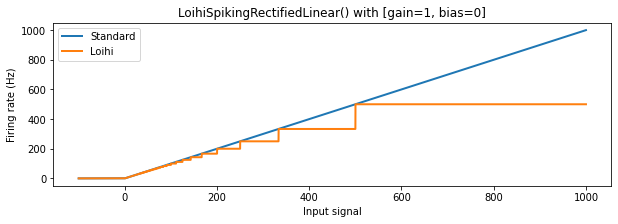

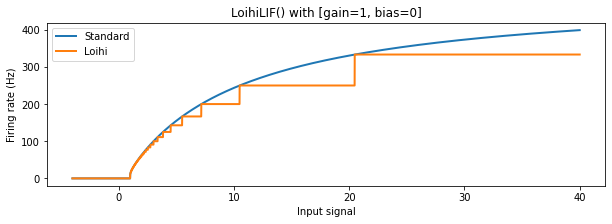

In [10]:
def plot_activation(neurons, min, max, **kwargs):
    x = np.arange(min, max, 0.001)
    fr = neurons.rates(x=x, gain=[1], bias=[0])

    plt.plot(x, fr, lw=2, **kwargs)
    plt.title("%s with [gain=1, bias=0]" % str(neurons))
    plt.ylabel("Firing rate (Hz)")
    plt.xlabel("Input signal")
    plt.legend(["Standard", "Loihi"], loc=2)


plt.figure(figsize=(10, 3))
plot_activation(nengo.RectifiedLinear(), -100, 1000)
plot_activation(nengo_loihi.neurons.LoihiSpikingRectifiedLinear(), -100, 1000)

plt.figure(figsize=(10, 3))
plot_activation(nengo.LIF(), -4, 40)
plot_activation(nengo_loihi.neurons.LoihiLIF(), -4, 40)

We can see that for lower firing rates the behaviour of the Loihi neurons approximates
the normal `relu` and `lif` neurons relatively well, but for higher firing rates the
discrepancy becomes larger. The discretization results in large plateus of input signal
values where the output firing rate from the neuron stays the same, making different
input values in this range indistinguishable. Also, as mentioned above, for input values
above 1000 (not shown) the `LoihiSpikingRectifiedLinear` neuron will have a constant
output of 1000 Hz (since this corresponds to one spike per timestep, the maximum firing
rate on Loihi); the `SpikingRectifiedLinear` neuron, on the other hand, is able to fire
faster than 1000 Hz by using multiple spikes per timestep.

We can now return to our original question: How do we pick good firing rates for each
layer? For outputs above 250 Hz, both Loihi activation functions show significant
deviations from the non-Loihi activation profiles; they also become more discontinuous
above this point. We therefore want to keep our maximum firing rates below 250 Hz. We
also need the firing rate to be high enough to generate sufficient spikes, so that
information can be transmitted from layer to layer in a reasonable time. For these
reasons, we'll choose a target mean firing rate for each layer to be 200. We'll generate
a scaling term for each layer individually to hit this target.

Test accuracy: 98.00%
"to-spikes" mean firing rate (example 0): 169.2
"conv0" mean firing rate (example 0): 123.1
"conv1" mean firing rate (example 0): 93.0
"dense0" mean firing rate (example 0): 44.0
"to-spikes" mean firing rate (example 1): 191.0
"conv0" mean firing rate (example 1): 138.5
"conv1" mean firing rate (example 1): 98.6
"dense0" mean firing rate (example 1): 45.3


array([180.12039 , 130.82814 ,  95.81003 ,  44.690475], dtype=float32)

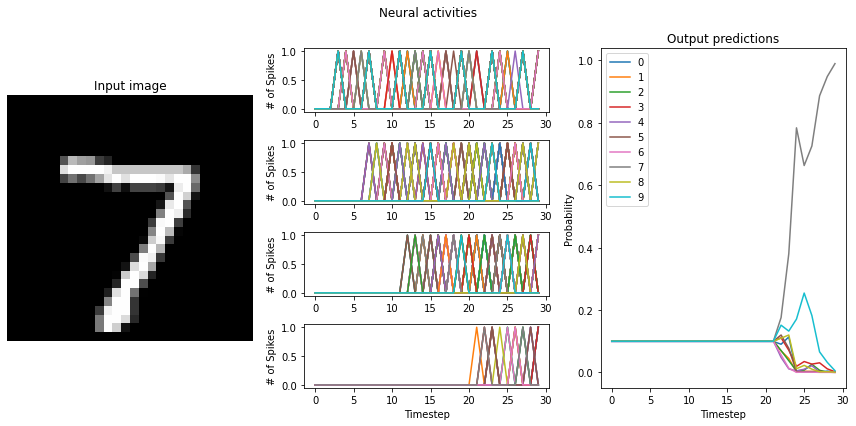

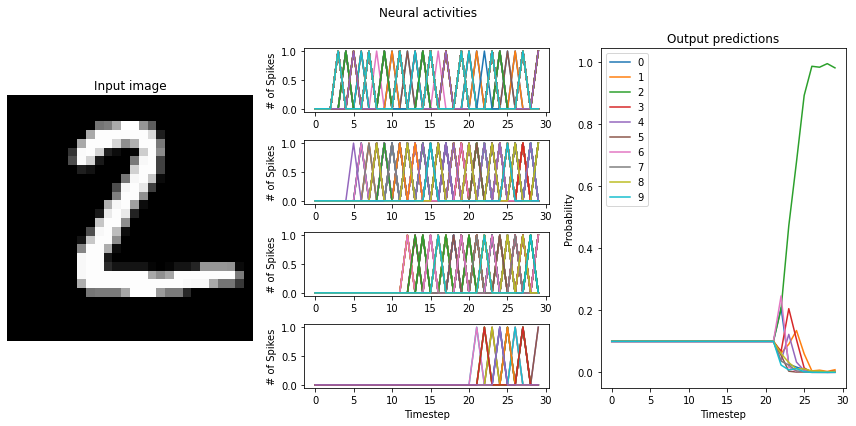

In [11]:
target_mean = 200
scale_firing_rates = {
    to_spikes_layer: target_mean / mean_rates[0],
    conv0_layer: target_mean / mean_rates[1],
    conv1_layer: target_mean / mean_rates[2],
    dense0_layer: target_mean / mean_rates[3],
}

# test the trained networks using spiking neurons
run_network(
    activation=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    scale_firing_rates=scale_firing_rates,
    synapse=0.005,
)

As we can see, when we individually scale the activity of each layer, we almost fully
recover non-spiking performance. Note that the firing rates of some layers (the later
layers in particular) do not quite meet the target mean firing rate of 200 Hz, though.
This is because our mean firing rates were measured using the `RectifiedLinear` neuron
type, and do not account for the difference between it and the
`LoihiSpikingRectifiedLinear` activation function. For better results, we could go back
and measure the mean firing rates using the Loihi neuron type, or hand-tune the scaling
factors on each layer to achieve the desired firing rates.

Alternatively, we can train our network using the `LoihiSpikingRectifiedLinear`. This
will account both for the discretization in the activation profile, and the hard limit
of 1 spike per time step. For larger or more complex networks this can save time tuning.

## Training with the Loihi neurons

We're going to use another trick for training and set `scale_firing_rates=100` _while_
training. What this does essentially is initiate the network with high firing rates,
such that during training we'll consistently find a local minima with higher firing
rates that will work well when we swap in spiking neurons. It also reduces the
discrepancy in firing rates between layers, starting them all off in a higher range.

This is a low-overhead, ad-hoc means of increasing the firing rates of neurons in each
layer, and does not guarantee that the network converges to a desired range of firing
rates for each layer after training. The firing rate regularization method—shown in a
basic form in the [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html) and in a more
powerful form in the [CIFAR-10 Loihi
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html)—is a more
consistent way to achieve the desired range of firing rates in each layer.

In [12]:
# train this network with normal ReLU neurons
train(
    params_file="./keras_to_loihi_loihineuron_params",
    epochs=2,
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
    scale_firing_rates=100,
)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/2
300/300 [==============================] - 6s 14ms/step - loss: 0.1944 - probe_loss: 0.1944 - probe_sparse_categorical_accuracy: 0.9392
Epoch 2/2
300/300 [==============================] - 4s 15ms/step - loss: 0.0613 - probe_loss: 0.0613 - probe_sparse_categorical_accuracy: 0.9807


Now when we run the network we need to be sure to again set the `scale_firing_rates`
parameter so that the training conditions are replicated.

Test accuracy: 99.00%
"to-spikes" mean firing rate (example 0): 869.9
"conv0" mean firing rate (example 0): 131.5
"conv1" mean firing rate (example 0): 84.2
"dense0" mean firing rate (example 0): 107.9
"to-spikes" mean firing rate (example 1): 874.7
"conv0" mean firing rate (example 1): 138.4
"conv1" mean firing rate (example 1): 85.2
"dense0" mean firing rate (example 1): 112.8


array([872.3013  , 134.93323 ,  84.713806, 110.35761 ], dtype=float32)

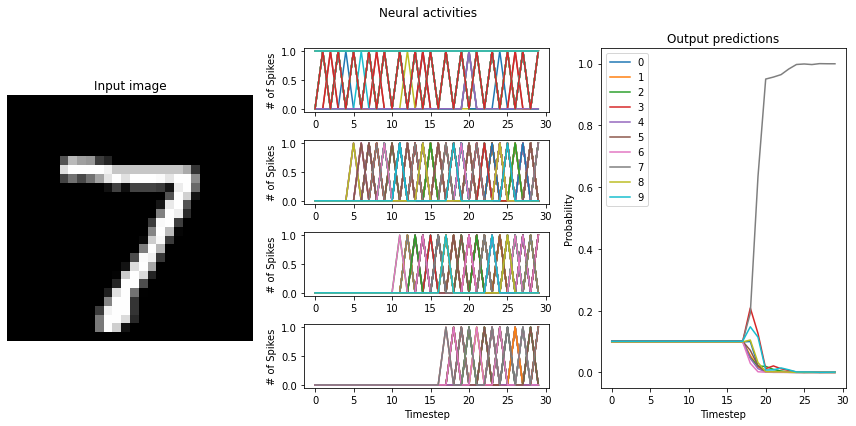

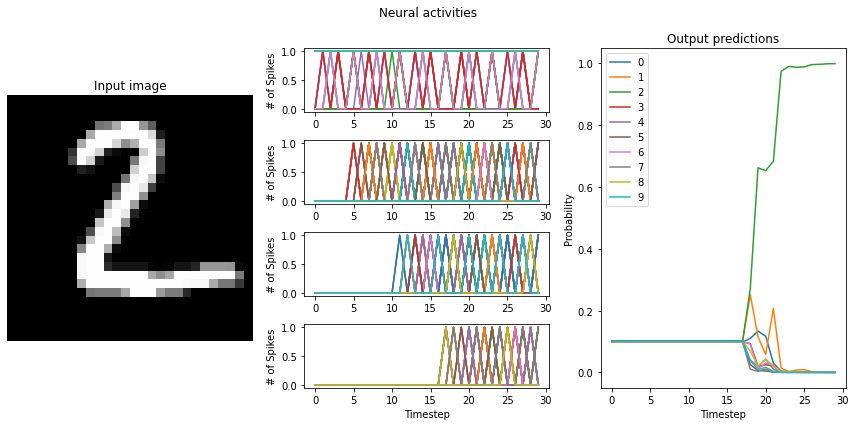

In [13]:
# test the trained networks using spiking neurons
run_network(
    activation=nengo_loihi.neurons.LoihiSpikingRectifiedLinear(),
    scale_firing_rates=100,
    params_file="./keras_to_loihi_loihineuron_params",
    synapse=0.005,
)

This is another way that we can recover normal ReLU performance using Loihi neurons.

As discussed in the [Keras to SNN
example](https://www.nengo.ai/nengo-dl/examples/keras-to-snn.html), we can also train up
this network using an extra term added to the loss function as a way of getting neurons
into the desired range of firing rates. This method has the benefit of being more
precise in the resultant firing rates of neurons in the network. When we set
`scale_firing_rates` to a large number during training, we're simply instantiating the
network with high firing rates and hoping it converges while maintaining these higher
firing rates, but there is no guarantee. Adding the rate regularization term to the loss
function ensures that the firing rates stay near their targets throughout the training
process.

## Running your SNN on Loihi

At this point we're ready to test out our network on the Loihi. To actually run it on
Loihi we have to set up a few more configuration parameters.

We'll start by converting our network same as before, using the same parameters on the
Converter call:

In [14]:
pres_time = 0.03  # how long to present each input, in seconds
n_test = 5  # how many images to test

# convert the keras model to a nengo network
nengo_converter = nengo_dl.Converter(
    model,
    scale_firing_rates=400,
    swap_activations={tf.nn.relu: nengo_loihi.neurons.LoihiSpikingRectifiedLinear()},
    synapse=0.005,
)
net = nengo_converter.net

# get input/output objects
nengo_input = nengo_converter.inputs[inp]
nengo_output = nengo_converter.outputs[dense1]

The next thing we need to do is load in the trained parameters. This involves creating a
NengoDL Simulator, loading in the weights, and then calling the
[`freeze_params`](https://www.nengo.ai/nengo-dl/reference.html#nengo_dl.Simulator.freeze_params)
function to save the weights to the network object. This will then let us build a
network with the trained weights inside the NengoLoihi Simulator.

In [15]:
# build network, load in trained weights, save to network
with nengo_dl.Simulator(net) as nengo_sim:
    nengo_sim.load_params("keras_to_loihi_loihineuron_params")
    nengo_sim.freeze_params(net)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


Before we build the network in NengoLoihi we need to make a few more changes.

The `input` Node needs to altered to generate our test images as output:

In [16]:
with net:
    nengo_input.output = nengo.processes.PresentInput(
        test_images, presentation_time=pres_time
    )

We specify that the `to_spikes` layer should run off-chip:

In [17]:
with net:
    nengo_loihi.add_params(net)  # allow on_chip to be set
    net.config[nengo_converter.layers[to_spikes].ensemble].on_chip = False

At this point, if you try to build the network you will get an error
>BuildError: Total synapse bits (1103808) exceeded max (1048576)

which means that too many connections are going into a single Loihi core. To fix this,
we need to specify the `block_shape` parameter on the convnet layers that are running on
the Loihi. This lets us break up our convnet layer across multiple cores and prevent us
from overloading a single core. The first parameter specifies the target size of the
representation per core with a (`rows`, `columns`, `channels`) tuple. The max neurons
per core is 1024, so `rows * columns * channels` must be less than 1024.

The second parameter is the size of the full layer. This [can be
calculated](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer)
with the `input_size`, `kernel_size`, `strides`, and `filters` parameters for the layer.
We do this in the `calculate_size` function below.

These parameters need to be tuned until the synapse and axon constraints are met. More
details on `block_shape` can be found in the [`BlockShape`
documentation](https://www.nengo.ai/nengo-loihi/api.html#nengo_loihi.BlockShape), with
details about how to choose good block shapes in the [tips and tricks
section](https://www.nengo.ai/nengo-loihi/tips.html#splitting-large-ensembles) of the
documentation and in the [CIFAR-10 Loihi
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html).

For this example, we are using the `(16, 16, 4)` for `conv0`, `(8, 8, 16)` for `conv1`,
and `(50,)` for our `dense0` (which breaks it up into two 50 neuron ensembles) to fit
our model on Loihi.

In [18]:
with net:
    conv0_shape = conv0_layer.output_shape[1:]
    net.config[
        nengo_converter.layers[conv0].ensemble
    ].block_shape = nengo_loihi.BlockShape((16, 16, 4), conv0_shape)

    conv1_shape = conv1_layer.output_shape[1:]
    net.config[
        nengo_converter.layers[conv1].ensemble
    ].block_shape = nengo_loihi.BlockShape((8, 8, 16), conv1_shape)

    dense0_shape = dense0_layer.output_shape[1:]
    net.config[
        nengo_converter.layers[dense0].ensemble
    ].block_shape = nengo_loihi.BlockShape((50,), dense0_shape)

Now we're ready to build the network and run it!

In [19]:
# build NengoLoihi Simulator and run network
with nengo_loihi.Simulator(net) as loihi_sim:
    loihi_sim.run(n_test * pres_time)

    # get output (last timestep of each presentation period)
    pres_steps = int(round(pres_time / loihi_sim.dt))
    output = loihi_sim.data[nengo_output][pres_steps - 1 :: pres_steps]

    # compute the Loihi accuracy
    loihi_predictions = np.argmax(output, axis=-1)
    correct = 100 * np.mean(loihi_predictions == test_labels[:n_test, 0, 0])
    print("Loihi accuracy: %.2f%%" % correct)

Loihi accuracy: 100.00%


Our accuracy print-out is 100%, and we can also plot the results to see for ourselves:

Text(0, 0.5, 'Probability')

<Figure size 864x288 with 0 Axes>

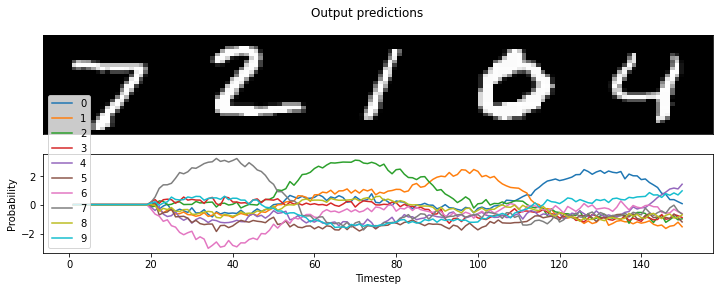

In [20]:
# plot the neural activity of the convnet layers
plt.figure(figsize=(12, 4))

timesteps = loihi_sim.trange() / loihi_sim.dt

# plot the presented MNIST digits
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
images = test_images.reshape(-1, 28, 28, 1)[:n_test]
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_test, nc), dtype=images.dtype)
for i, image in enumerate(images[:n_test]):
    allimage[:, i * nj : (i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
plt.imshow(allimage, aspect="auto", interpolation="none", cmap="gray")
plt.xticks([])
plt.yticks([])

# plot the network predictions
plt.subplot(2, 1, 2)
plt.plot(timesteps, loihi_sim.data[nengo_output])
plt.legend(["%d" % i for i in range(10)], loc="lower left")
plt.suptitle("Output predictions")
plt.xlabel("Timestep")
plt.ylabel("Probability")

## Conclusions

In this example we've expanded on the process of converting a Keras model to an SNN with
additional considerations that are important for SNN's we want to implement on the
Loihi. We then showed the additional steps required to prepare a network generated by
the NengoDL Converter to run on Loihi, including modifying the input node and specifying
the distribution of convnet layers across cores.